# Projet P6 - Classifiez automatiquement des biens de consommation
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 05/2024*
<hr>

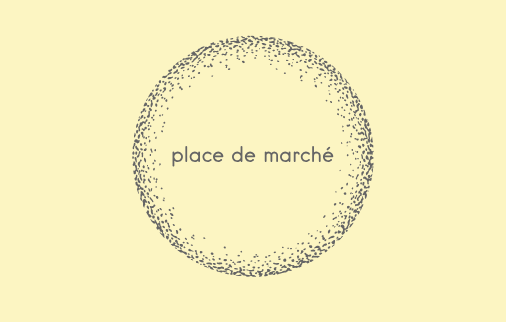

## <font color='#46abe6'>Contexte</font>
Place de marché est un site de e-commerce où des vendeurs proposent des articles à des acheteurs en postant une photo et une description.
 
Actuellement, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
 
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.
 
L'objectif de ce projet est d'étudier la faisablité d'un moteur de classification à partir de la description textuelle ou de l'image du produit.

## <font color='#46abe6'>Sommaire</font>

<span style='background:#46abe6'><span style='color:white'>**Partie 1 - Données textuelles - Analyse exploratoire des données**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 2 - Données textuelles - Feature extraction et faisabilité**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 3 - Images - Analyse exploratoire des données**</span></span>

<span style='background:#d5155b'><span style='color:white'>**Partie 4 - Images - Feature extraction et faisabilité**</span></span>

[Importation des librairies + fonctions + données](#1)
* [Importation des librairies](#1_1)
* [Fonctions](#1_2)
* [Importation des données](#1_3)

[ORB (Oriented FAST and Rotated BRIEF)](#2)
* [Features extraction](#2_1)
* [Création des clusters de descripteurs](#2_2)
* [Création des features images](#2_3)
* [Réduction de dimensions par PCA](#2_4)
* [Exportation des features extraites](#2_5)


<span style='background:#46abe6'><span style='color:white'>**Partie 5 - Images - Classification**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 6 - Images - Requête API**</span></span>

# <font color='#0a389f'>Importation librairies + fonctions<a class="anchor" id="1"></a></font>

## <font color='#46abe6'>Importation des librairies<a class="anchor" id="1_1"></a></font>

In [1]:
import numpy as np
import pandas as pd

# graphiques
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import pickle

from sklearn import preprocessing, cluster, metrics, manifold, decomposition

from matplotlib.image import imread
from PIL import Image, ImageOps, ImageFilter
import cv2

In [2]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.24.4
pandas - 2.2.2
seaborn - 0.13.2
PIL.Image - 9.4.0
cv2 - 4.10.0


In [3]:
# Paramètres par défauts des graphiques
sns.set_style('whitegrid')        # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
width = 7
height = 5
plt.figure(figsize=(width, height))
meanprops = {'marker':'o', 'markeredgecolor':'black','markerfacecolor':'firebrick'}

<Figure size 700x500 with 0 Axes>

## <font color='#46abe6'>Fonctions<a class="anchor" id="1_2"></a></font>

In [4]:
def orbFeatureExtractor(img_path):
    """!
    @brief Extrait des descripteurs ORB pour une image.

    Cette fonction utilise le détecteur ORB pour extraire des descripteurs d'une image.

    @param img_path: Chemin d'accès de l'image (str).
    @return descriptor: Descripteurs ORB de l'image valide (np.array).
    """
    # Lire l'image en couleur et vérifier si l'image a été correctement chargée
    img = imread(img_path)
    if img is None:
        print(f"Erreur de chargement de l'image : {img_path}")

    # Convertir l'image en niveaux de gris
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    contrast_img = cv2.equalizeHist(img_gray)

    # Détecter les points clés et calculer les descripteurs
    kp, desc = orb.detectAndCompute(contrast_img, None)

    # Vérifier si des descripteurs ont été trouvés
    if desc is None:
        print(f"Erreur lors de la détection des descripteurs pour l'image : {img_file}")
    
    return kp, desc

In [5]:
def pad_descriptors(descriptor_list, max_length):
    """!
    @brief Remplit les descripteurs pour qu'ils aient tous la même longueur maximale.

    Cette fonction prend une liste de descripteurs et les remplit de zéros pour qu'ils aient tous
    une longueur égale à `max_length`. Si un descripteur a déjà la longueur maximale ou plus, il reste inchangé.

    @param descriptor_list: Liste de descripteurs à remplir (list of np.ndarray).
    @param max_length: Longueur maximale à laquelle chaque descripteur doit être rempli (int).
    @return np.ndarray: Tableau numpy contenant les descripteurs remplis.

    @throws ValueError: Si un descripteur dans la liste a une dimension incorrecte.
    """
    padded_descriptors = []
    for descriptor in descriptor_list:
        current_length = descriptor.shape[0]
        
        if current_length > max_length:
            raise ValueError(f"Le descripteur a une longueur ({current_length}) supérieure à max_length ({max_length}).")
        
        if current_length < max_length:
            # Calculer la quantité de padding requise
            padding_needed = max_length - current_length
            # Ajouter des zéros pour remplir
            padded_descriptor = np.pad(descriptor, ((0, padding_needed), (0, 0)), 'constant')
        else:
            padded_descriptor = descriptor
            
        padded_descriptors.append(padded_descriptor)
    
    return np.array(padded_descriptors)

In [6]:
def build_histogram(kmeans, desc, image_num):
    """!
    @brief Construit un histogramme de fréquences des clusters pour les descripteurs d'une image.

    Cette fonction utilise un modèle K-means pour prédire les clusters des descripteurs d'une image,
    puis construit un histogramme où chaque bin représente la fréquence relative des clusters
    auxquels les descripteurs de l'image appartiennent.

    @param kmeans: Modèle K-means pré-entraîné pour prédire les clusters (sklearn.cluster.KMeans).
    @param desc: Tableau numpy des descripteurs pour l'image (np.ndarray).
    @param image_num: Numéro ou identifiant de l'image pour le débogage (int).
    @return np.ndarray: Histogramme de fréquences des clusters (np.ndarray).

    @throws ValueError: Si le nombre de descripteurs est nul, un message d'erreur est affiché.
    """
    res = kmeans.predict(desc)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_desc = len(desc)
    
    if nb_desc == 0:
        raise ValueError(f"Problème histogramme pour l'image numéro : {image_num}")

    for i in res:
        hist[i] += 1.0 / nb_desc
    
    return hist

## <font color='#46abe6'>Importation et inspection des données<a class="anchor" id="2_1"></a></font>

In [7]:
# Importation des données
data = pd.read_pickle('image_data.pkl')
display(data.head())

,uniq_id,image,main_category,sub_category
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Curtains & Accessories
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Baby Bath & Skin
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Baby Bath & Skin
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,Bed Linen
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Bed Linen


In [8]:
# Chemin du répertoire des images et liste des noms des images
path = 'C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/Dataset+projet+prétraitement+textes+images/Flipkart/Images/'
list_images = data['image'].values

# <font color='#0a389f'>ORB (Oriented FAST and Rotated BRIEF)<a class="anchor" id="2"></a></font>

Dans un premier temps, nous allons tester un modèle de type SIFT, SURF ou ORB.
La comparaison des modèles d'après l'article [Comparison of SIFT, SURF and ORB on OpenCV](https://mikhail-kennerley.medium.com/a-comparison-of-sift-surf-and-orb-on-opencv-59119b9ec3d0) conclue que ORB est un bon compromis en terme de rapidité d'exécution et de qualité des résultats. Nous allons donc utiliser ce modèle pour un premier essai.

## <font color='#46abe6'>Features extraction<a class="anchor" id="2_1"></a></font>
* Pour chaque image, passage en gris et equalisation, extraction des features avec ORB
* Création d'une liste de descripteurs par image ("descriptor_by_img") qui sera utilisée pour réaliser les histogrammes par image
* Création d'une liste de descripteurs pour l'ensemble des images ("descriptor_all") qui sera utilisé pour créer les clusters de descripteurs

In [9]:
# Initialiser l'extracteur ORB et la liste pour stocker les descripteurs de chaque image
orb = cv2.ORB_create(nfeatures=500)
descriptor_list = []
keypoint_list = []

temps1=time.time()

# Parcourir chaque fichier image dans la liste
for img_file in list_images:

    # Construire le chemin complet de l'image
    img_path = os.path.join(path, img_file)
        
    kp, desc = orbFeatureExtractor (img_path)
    
    descriptor_list.append(desc)
    keypoint_list.append(kp)

# Trouver la longueur maximale des descripteurs
max_length = max(descriptor.shape[0] for descriptor in descriptor_list)

# Remplir les descripteurs
padded_descriptors = pad_descriptors(descriptor_list, max_length)

# Combiner les descripteurs en une matrice numpy
descriptor_by_img = np.array(padded_descriptors)

descriptor_all    = np.concatenate(descriptor_by_img, axis=0)

print("Nombre de descripteurs : ", descriptor_all .shape)

duration1=time.time()-temps1
print("Temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

C:\Users\Adeline\anaconda3\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Nombre de descripteurs :  (535500, 32)
Temps de traitement ORB descriptor :            41.68 secondes


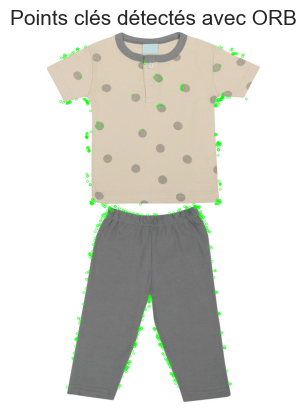

In [10]:
# Dessiner les points clés sur l'image
img_index = 42
img_path = os.path.join(path, list_images[img_index])
img = imread(img_path)
image_with_keypoints = cv2.drawKeypoints(img, keypoint_list[img_index], None, color=(0, 255, 0))

# Afficher l'image avec les points clés
plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Points clés détectés avec ORB')
plt.axis('off')
plt.show()

## <font color='#46abe6'>Création des clusters de descripteurs<a class="anchor" id="2_2"></a></font>
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [11]:
# Determination du nombre de clusters
temps1=time.time()

k = int(round(np.sqrt(len(descriptor_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(descriptor_all)

duration1=time.time()-temps1
print("Temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  732
Création de 732 clusters de descripteurs ...
Temps de traitement kmeans :             5.62 secondes


## <font color='#46abe6'>Création des features des images<a class="anchor" id="2_3"></a></font>
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image
   Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [12]:
# Creation of histograms (features)
temps1=time.time()

# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(descriptor_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.30 secondes


## <font color='#46abe6'>Réduction de dimensions par PCA<a class="anchor" id="2_4"></a></font>
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [13]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 732)
Dimensions dataset après réduction PCA :  (1050, 568)


## <font color='#46abe6'>Exportation des features extraites<a class="anchor" id="2_5"></a></font>

In [14]:
with open('features_orb.pkl', 'wb') as file:
    pickle.dump(feat_pca, file)